# 01 Introduction

In [52]:
import jax.random
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats

import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

az.style.use("arviz-darkgrid")
rng_key = random.PRNGKey(0)
numpyro.set_platform("cpu")

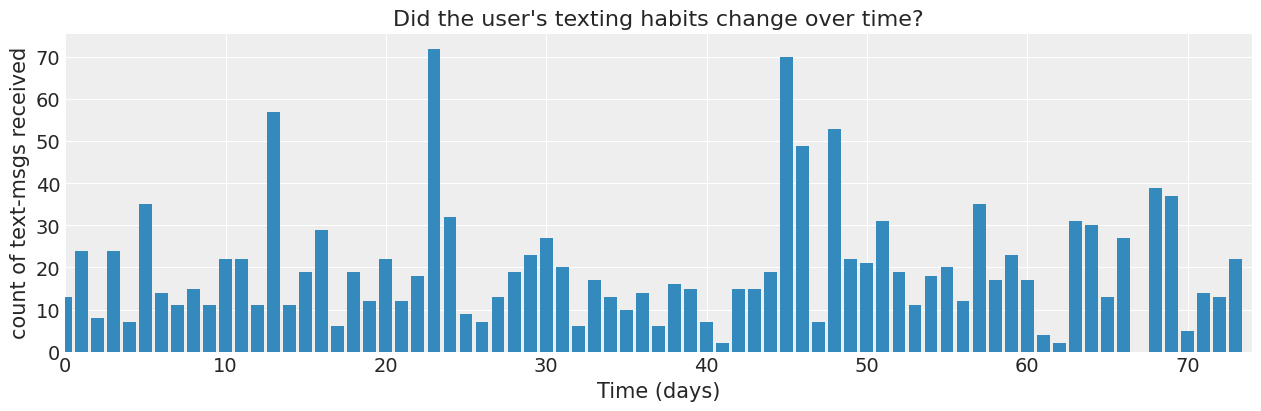

In [53]:
PATH = 'txtdata.csv'

plt.figure(figsize=(12.5, 4))

count_data = np.loadtxt(PATH)
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

In [54]:
def model(data):
  n_data = len(data)

  alpha = 1.0 / data.mean() # 受信数の平均の逆数（なぜこのように設定するかについては参考書を参照）
  lambda_1 = numpyro.sample("lambda_1", dist.Exponential(rate=alpha))
  lambda_2 = numpyro.sample("lambda_2", dist.Exponential(rate=alpha))

  tau = numpyro.sample("tau", dist.Uniform(low=0, high=n_data))

  idx = jnp.arange(n_data) # Index
  with numpyro.plate("data_plate", n_data):
    lambda_ = numpyro.deterministic("lambda_", jnp.where(tau > idx, lambda_1, lambda_2))
  numpyro.sample("obs", dist.Poisson(rate=lambda_), obs=data)

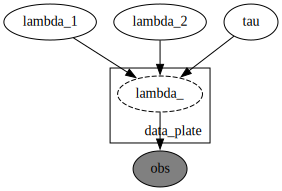

In [55]:
numpyro.render_model(model, model_args=(count_data,))

In [56]:
rng_key, rng_key_ = random.split(rng_key)

kernel = NUTS(model)
sample_kwargs = dict(
    sampler=kernel, num_warmup=1000, num_samples=1000, num_chains=1, chain_method="parallel"
)
mcmc = MCMC(**sample_kwargs)
mcmc.run(rng_key_, data=count_data)

sample: 100%|██████████| 2000/2000 [00:04<00:00, 434.22it/s, 1023 steps of size 1.40e-03. acc. prob=0.85]


In [57]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  lambda_1     17.72      0.62     17.69     16.76     18.74     63.15      1.00
  lambda_2     22.66      0.91     22.59     21.12     24.13    141.47      1.01
       tau     43.65      0.91     43.79     42.30     44.99     47.49      1.00

Number of divergences: 0


In [58]:
mcmc.get_samples()

{'lambda_': Array([[17.509542, 17.509542, 17.509542, ..., 22.237938, 22.237938,
         22.237938],
        [17.30659 , 17.30659 , 17.30659 , ..., 22.601326, 22.601326,
         22.601326],
        [17.9296  , 17.9296  , 17.9296  , ..., 22.095776, 22.095776,
         22.095776],
        ...,
        [18.318348, 18.318348, 18.318348, ..., 24.515247, 24.515247,
         24.515247],
        [17.842316, 17.842316, 17.842316, ..., 23.71436 , 23.71436 ,
         23.71436 ],
        [17.863241, 17.863241, 17.863241, ..., 23.216055, 23.216055,
         23.216055]], dtype=float32),
 'lambda_1': Array([17.509542, 17.30659 , 17.9296  , 17.862751, 17.978325, 18.072893,
        18.082798, 18.587112, 19.07164 , 18.42826 , 18.007479, 17.834309,
        17.84293 , 17.657528, 17.859493, 17.936222, 17.693045, 17.777973,
        17.392822, 17.082123, 17.198442, 17.131544, 17.26888 , 17.386251,
        17.81536 , 17.834839, 17.921543, 17.28853 , 17.398525, 17.065495,
        17.15109 , 17.561676, 17.5763

In [59]:
mcmc.get_samples()["lambda_1"][:5]

Array([17.509542, 17.30659 , 17.9296  , 17.862751, 17.978325], dtype=float32)

In [60]:
idata = az.from_numpyro(mcmc)

In [61]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

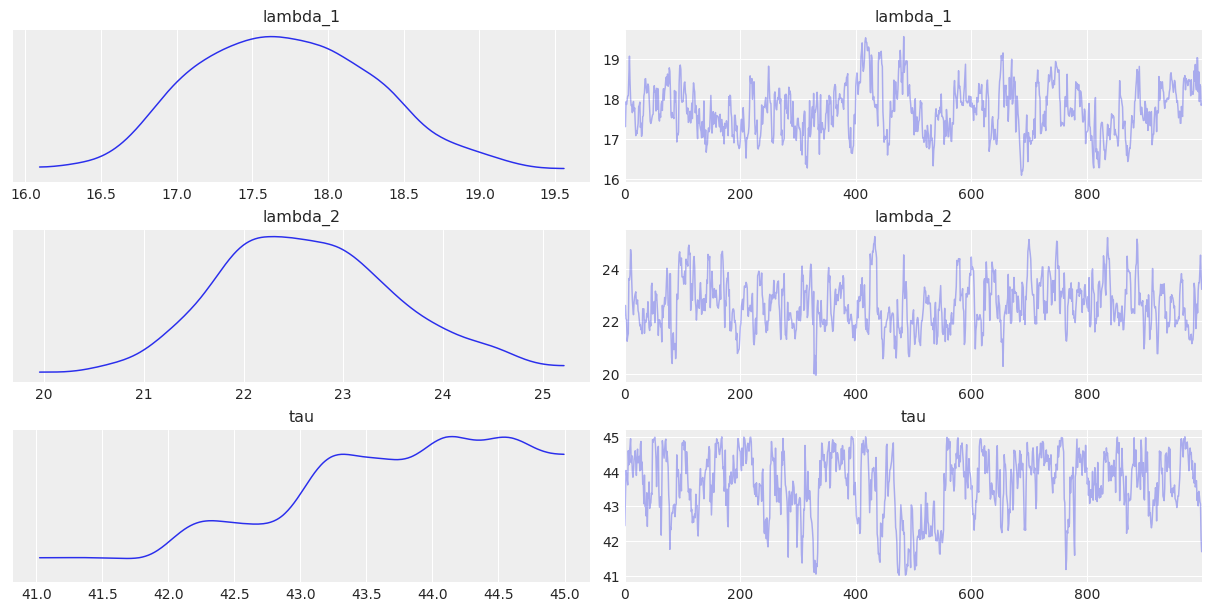

In [62]:
var_names = ["lambda_1", "lambda_2", "tau"]
az.plot_trace(idata, var_names=var_names);

#### try original doc's code.

In [63]:
lambda_1_samples = mcmc.get_samples()["lambda_1"][:]
lambda_2_samples = mcmc.get_samples()["lambda_2"][:]
tau_samples = mcmc.get_samples()["tau"][:]

Text(0, 0.5, 'probability')

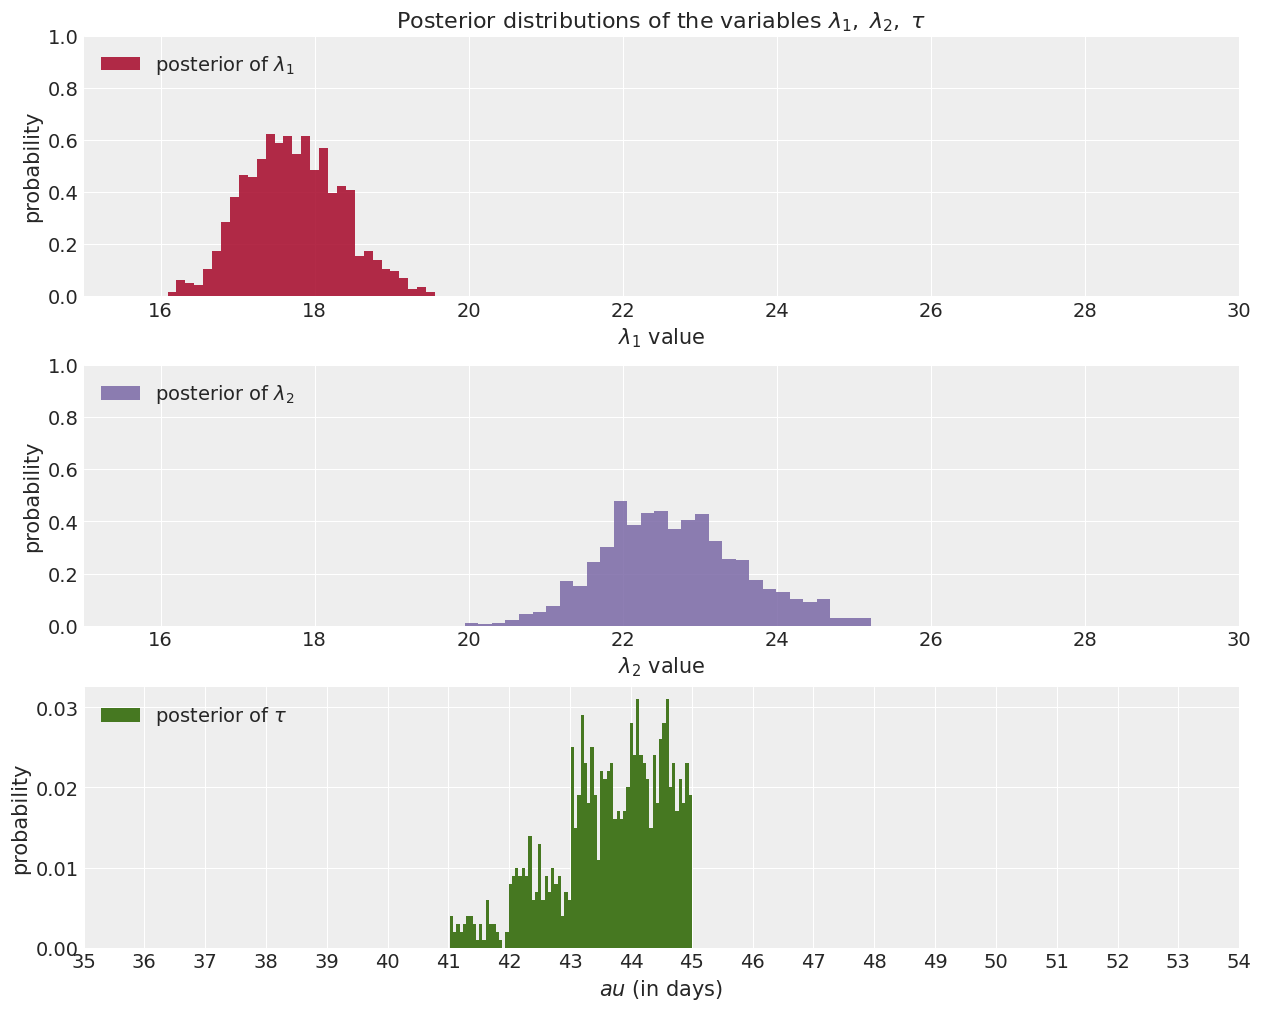

In [65]:
plt.figure(figsize=(12.5, 10))

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("probability")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")
plt.ylabel("probability")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1, label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.xlim([35, len(count_data) - 20])
plt.xlabel("$\tau$ (in days)")
plt.ylabel("probability")


#### code ported by chatgpt
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb

sample: 100%|██████████| 15000/15000 [00:17<00:00, 879.78it/s, 1023 steps of size 7.31e-04. acc. prob=0.71] 


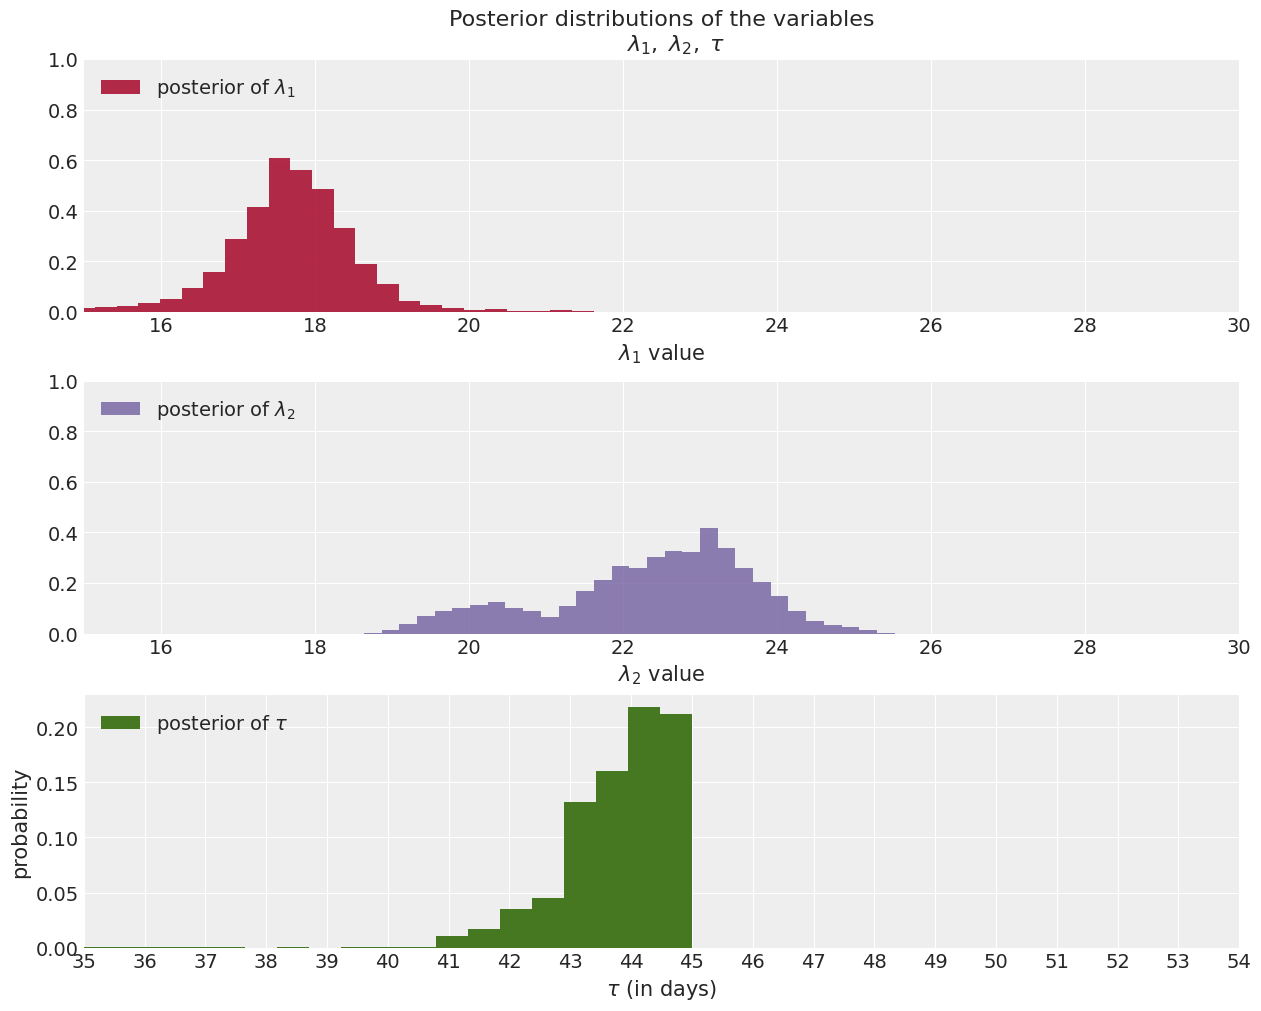

In [66]:
import jax.numpy as jnp
from jax import random
import numpyro
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt

# Data
#count_data = jnp.array( ...) # replace with your actual count_data
n_count_data = len(count_data)

# Model
def model(n_count_data, count_data):
    alpha = 1.0/jnp.mean(count_data)
    lambda_1 = numpyro.sample("lambda_1", numpyro.distributions.Exponential(alpha))
    lambda_2 = numpyro.sample("lambda_2", numpyro.distributions.Exponential(alpha))
    tau = numpyro.sample("tau", numpyro.distributions.Uniform(0, n_count_data))
    idx = jnp.arange(n_count_data)
    lambda_ = jnp.where(tau > idx, lambda_1, lambda_2)
    numpyro.sample("obs", numpyro.distributions.Poisson(lambda_), obs=count_data)

# Inference
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=5000, num_samples=10000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, n_count_data=n_count_data, count_data=count_data)

# Extract samples
posterior_samples = mcmc.get_samples()
lambda_1_samples = posterior_samples['lambda_1']
lambda_2_samples = posterior_samples['lambda_2']
tau_samples = posterior_samples['tau']

# Plotting
plt.figure(figsize=(12.5, 10))

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * jnp.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(jnp.arange(n_count_data))

plt.legend(loc="upper left")
plt.xlim([35, n_count_data - 20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability")
plt.show()

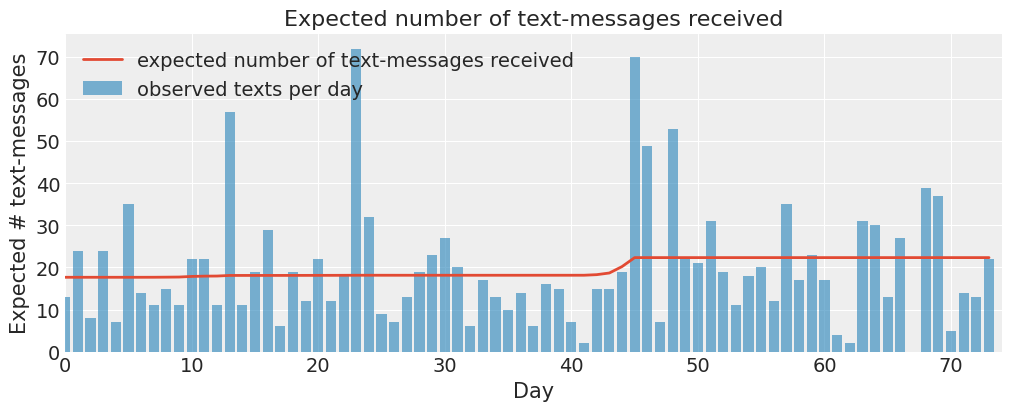

In [67]:
plt.figure(figsize=(10, 4))

# tau_samples, lambda_1_samples, lambda_2_samples は
# それぞれ対応する事後分布からのN個のサンプルを含んでいる。
N = tau_samples.shape[0]

expected_texts_per_day = np.zeros(n_count_data)
for day in range(n_count_data):
  # ix is a bool index of all tau samples corresponding to
  # the switchpoint occurring prior to value of 'day'
  ix = day < tau_samples
  # Each posterior sample corresponds to a value for tau.
  # for each day, that value of tau indicates whether we're "before"
  # (in the lambda1 "regime") or
  #  "after" (in the lambda2 "regime") the switchpoint.
  # by taking the posterior sample of lambda1/2 accordingly, we can average
  # over all samples to get an expected value for lambda on that day.
  # As explained, the "message count" random variable is Poisson distributed,
  # and therefore lambda (the poisson parameter) is the expected value of
  # "message count".
  expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=2, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

# 02 NumPyro入門 (1)

In [68]:
rng_key = random.PRNGKey(0)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

In [69]:
print(f"Running on NumPyro v{numpyro.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on NumPyro v0.12.1
Running on ArviZ v0.15.1


In [70]:
def model(data=None):
    lambda_ = numpyro.sample('lambda_', dist.Exponential(1), obs=data)

In [73]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000)
rng_key, rng_key_ = random.split(rng_key)
mcmc.run(rng_key_)

sample: 100%|██████████| 2000/2000 [00:02<00:00, 689.85it/s, 1 steps of size 8.28e-01. acc. prob=0.88] 


array([[<Axes: title={'center': 'lambda_'}>,
        <Axes: title={'center': 'lambda_'}>]], dtype=object)

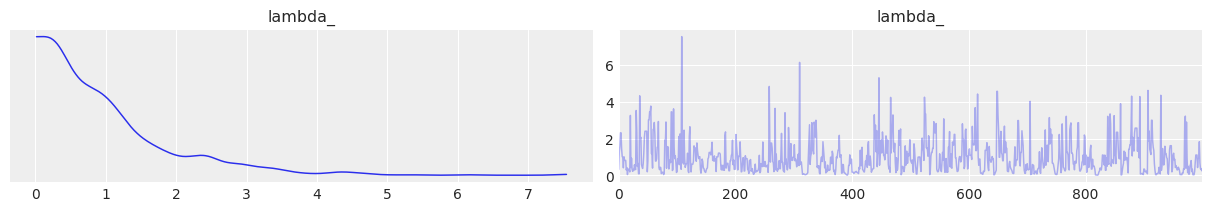

In [74]:
idata = az.from_numpyro(mcmc)
az.plot_trace(idata)

In [75]:
def model(data=None):
    mu = numpyro.sample('mu', dist.Normal(0, 1))
    obs = numpyro.sample('obs', dist.Normal(mu, 1), obs=data)

In [76]:
rng_key, rng_key_ = random.split(rng_key)
observed = jax.random.normal(rng_key_, (100,))

In [77]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
rng_key, rng_key_ = random.split(rng_key)
mcmc.run(rng_key_, data=observed)

C:\Users\yoshi\AppData\Local\Temp\ipykernel_9724\2021168712.py:2: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
sample: 100%|██████████| 2000/2000 [00:00<00:00, 4760.71it/s, 3 steps of size 8.94e-01. acc. prob=0.94]


In [78]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.10      0.10     -0.11     -0.25      0.07    917.61      1.00

Number of divergences: 0


In [79]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=1000, num_chains=2)
rng_key, rng_key_ = random.split(rng_key)
mcmc.run(rng_key_, data=observed)

C:\Users\yoshi\AppData\Local\Temp\ipykernel_9724\360416303.py:2: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=4000, num_samples=1000, num_chains=2)
sample: 100%|██████████| 5000/5000 [00:01<00:00, 4789.30it/s, 7 steps of size 8.75e-01. acc. prob=0.94]


In [80]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.10      0.10     -0.10     -0.28      0.05    725.98      1.00

Number of divergences: 0
